In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
df = pd.read_csv('./combined_wtcd.csv')
df

,rating,combined,action,comic,daily,drama,fantasy,historical,pure,sensibility,sports,thrill,story,episode,omnibus
0,9.30,예수 다이어리 기독교 세상 제일 날 예수 안티 크리스천 예수 일상 토요일 업데이트,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
1,9.89,애 하숙집 꼬마 하숙 생,0,1,1,0,0,0,0,0,0,0,0.0,0.0,1.0
2,9.85,섭식장애 일기 섭식장애,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
3,9.77,오늘 후기 여러분 오늘 무슨 매일 김 그림 일기 오늘 후기 자유 연재,0,1,1,0,0,0,0,0,0,0,0.0,1.0,0.0
4,9.73,제제 출산 육아 처음 초보 맘 첫째 아들 둘째 딸 출산 첫째 아이 자폐 진단 연년생...,0,0,1,1,0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,9.59,혈 고교 농구 리그,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0
3188,9.79,모두 추억 월드컵 그날 감동 다시 한번,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0
3189,9.79,공 각기 다른 문제 제자리 네 명의 청춘 길거리 농구대회 우승 목표 가지 전국 여행,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0
3190,9.83,샌프란시스코 화랑 관 샌프란시스코 화랑 관 태권도 한국인 가야,0,0,0,0,0,0,0,0,1,0,0.0,0.0,1.0


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['combined'])
counts = tokenizer.word_counts
num_rare_words = len([word for word, count in counts.items() if count < 2])
tokenizer.num_words = len(counts) - num_rare_words

In [5]:
sequences = tokenizer.texts_to_sequences(df['combined'])
# Pad sequences
max_length = max(len(sequence) for sequence in sequences)
X_text = pad_sequences(sequences, maxlen=max_length)

In [6]:
X_one_hot = df.drop(columns=['combined', 'rating']).values
X = np.concatenate([X_text, X_one_hot], axis=1)
y = df['rating'].values

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2)
X_one_hot_train, X_one_hot_test, _, _ = train_test_split(X_one_hot, y, test_size=0.2)

In [1]:
from keras import backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [8]:

inputA = Input(shape=(max_length,))
inputB = Input(shape=(df.drop(columns=['combined', 'rating']).shape[1],))

x = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, name='embedding_layer')(inputA)
conv = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(conv)
x_branch = Model(inputs=inputA, outputs=x)

y = Dense(128, activation="relu")(inputB)
y = Dropout(0.2)(y)
y = Dense(64, activation="relu")(y)
y_branch = Model(inputs=inputB, outputs=y)

combined = concatenate([x_branch.output, y_branch.output])
z = Dense(1, activation="linear")(combined)
model = Model(inputs=[x_branch.input, y_branch.input], outputs=z)

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[MeanSquaredError(name='mse'), 
                       RootMeanSquaredError(name='rmse'), 
                       MeanAbsoluteError(name='mae'),
                       r2_score])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best-CNN-model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(
    [X_text_train, X_one_hot_train], y_train,
    validation_data=([X_text_test, X_one_hot_test], y_test),
    epochs=10, callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
78/80 [============================>.] - ETA: 0s - loss: 19.3166 - mse: 19.3166 - rmse: 4.3951 - mae: 2.9659 - r2_score: -208.5858
Epoch 1: val_loss improved from inf to 0.20278, saving model to best-CNN-model.h5
80/80 [==============================] - 5s 22ms/step - loss: 18.8881 - mse: 18.8881 - rmse: 4.3460 - mae: 2.9061 - r2_score: -203.4199 - val_loss: 0.2028 - val_mse: 0.2028 - val_rmse: 0.4503 - val_mae: 0.2871 - val_r2_score: -0.7189
Epoch 2/10
78/80 [============================>.] - ETA: 0s - loss: 0.2287 - mse: 0.2287 - rmse: 0.4782 - mae: 0.3074 - r2_score: -0.8026
Epoch 2: val_loss improved from 0.20278 to 0.15741, saving model to best-CNN-model.h5
80/80 [==============================] - 1s 18ms/step - loss: 0.2297 - mse: 0.2297 - rmse: 0.4793 - mae: 0.3060 - r2_score: -0.7895 - val_loss: 0.1574 - val_mse: 0.1574 - val_rmse: 0.3967 - val_mae: 0.2534 - val_r2_score: -0.3055
Epoch 3/10
78/80 [============================>.] - ETA: 0s - loss: 0.1984 - mse: 0.1984

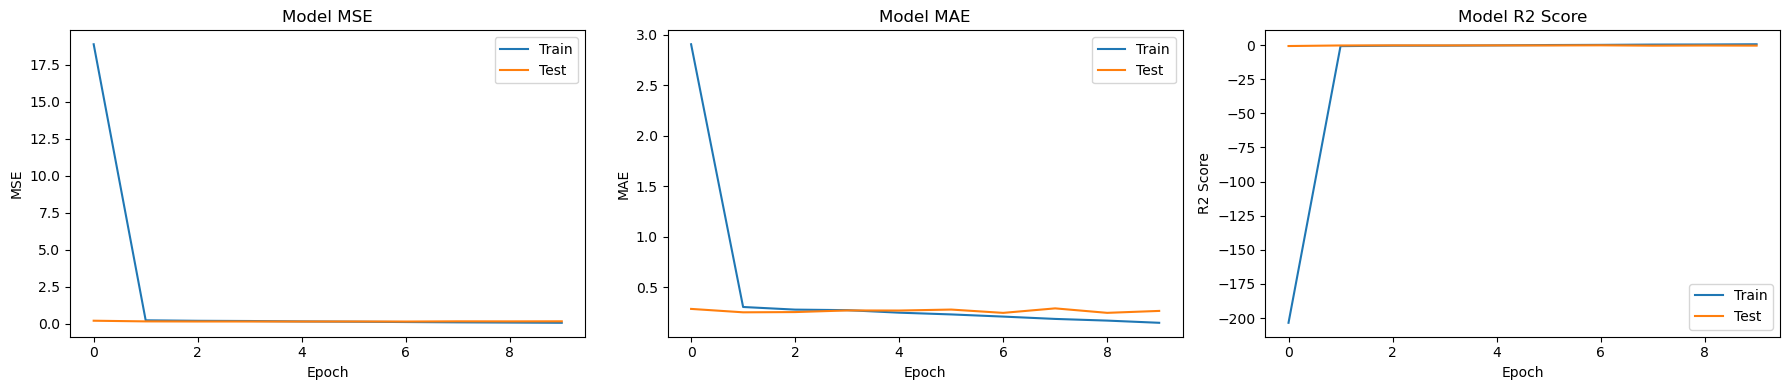

In [10]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1, 3, 3)
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('Model R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.tight_layout()
plt.show()

In [23]:
test_rmse = {}
genres = ['action', 'comic', 'daily', 'drama', 'fantasy', 'historical', 'pure', 'sensibility', 'sports', 'thrill']

for genre in genres:
    X_text_test_genre = X_text_test[df_test[genre] == 1]
    X_one_hot_test_genre = X_one_hot_test[df_test[genre] == 1]
    y_test_genre = y_test[df_test[genre] == 1]
    predictions = model.predict([X_text_test_genre, X_one_hot_test_genre])
    rmse = sqrt(mean_squared_error(y_test_genre, predictions))
    test_rmse[genre] = rmse

2/2 [==============================] - 0s 3ms/step


In [24]:
for genre, rmse in test_rmse.items():
    print(f"Test RMSE for {genre}: {rmse}")

Test RMSE for action: 0.2841052503511028
Test RMSE for comic: 0.3255532092165082
Test RMSE for daily: 0.3692141503629689
Test RMSE for drama: 0.4094095509714286
Test RMSE for fantasy: 0.3989919825458052
Test RMSE for historical: 0.33215760270077355
Test RMSE for pure: 0.45254906682115364
Test RMSE for sensibility: 0.38914401166455986
Test RMSE for sports: 0.5836017906689639
Test RMSE for thrill: 0.5407423373774217


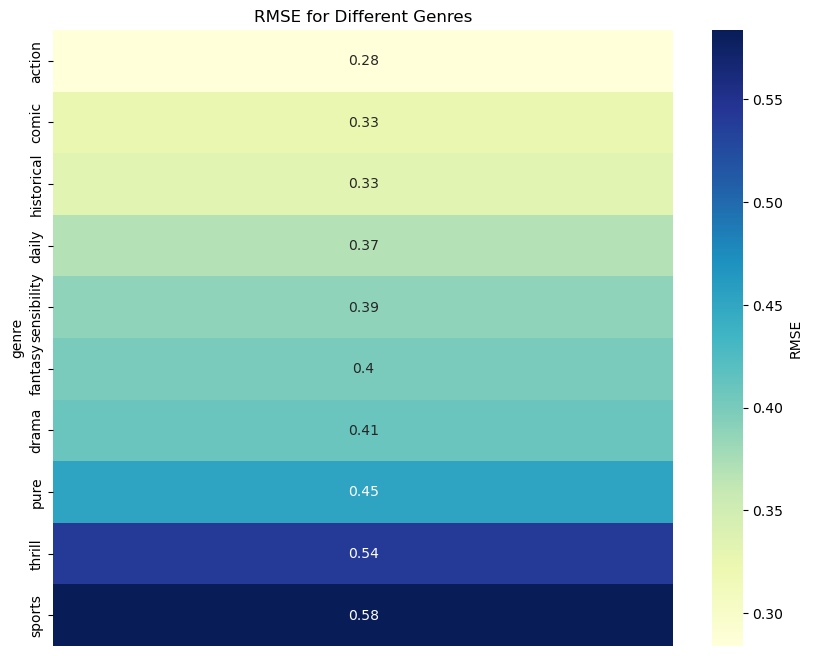

In [29]:
df_rmse = df_rmse.sort_values('rmse')

plt.figure(figsize=(10, 8))
sns.heatmap(df_rmse.set_index('genre'), annot=True, cmap="YlGnBu", cbar_kws={'label': 'RMSE'})
plt.title('RMSE for Different Genres')
plt.xticks(ticks=[])
plt.show()

In [32]:
embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding_layer').output)
embeddings = embedding_model.predict([X_text_train, X_one_hot_train])

80/80 [==============================] - 0s 1ms/step


c:\Users\gjaischool\anaconda3\lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:150: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
c:\Users\gjaischool\anaconda3\lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:166: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


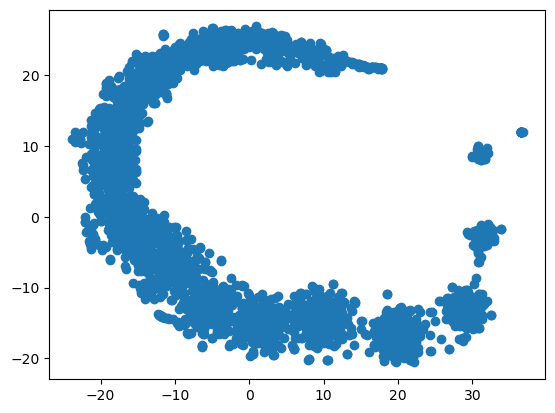

In [35]:
from sklearn.manifold import TSNE

embeddings = embeddings.mean(axis=1)
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
import umap

embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding_layer').output)
genre_embeddings = embedding_model.predict([X_text_train, X_one_hot_train])
genre_embeddings = genre_embeddings.mean(axis=1)

scaler = MinMaxScaler()
genre_embeddings_scaled = scaler.fit_transform(genre_embeddings)

reducer = umap.UMAP()
genre_embeddings_umap = reducer.fit_transform(genre_embeddings_scaled)

df_umap = pd.DataFrame(genre_embeddings_umap, columns=['x', 'y'])

80/80 [==============================] - 0s 1ms/step


In [13]:
df_umap

,x,y,action,comic,daily,drama,fantasy,historical,pure,sensibility,sports,thrill,story,episode,omnibus
0,-3.416592,17.982874,0,0,0,0,1,0,0,0,0,0,1.0,0.0,0.0
1,1.424518,7.359363,1,0,0,0,1,0,0,0,0,0,1.0,0.0,0.0
2,1.010673,9.945923,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
3,-0.462990,14.381463,0,1,1,0,0,0,0,0,0,0,1.0,0.0,0.0
4,-0.266178,14.701625,0,0,0,0,1,0,1,0,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2548,2.003157,5.357522,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
2549,1.978662,2.042464,0,1,1,0,0,0,0,0,0,0,0.0,1.0,0.0
2550,13.446719,-3.471531,0,0,0,0,1,0,0,0,0,0,1.0,0.0,0.0
2551,1.892577,3.972666,0,0,0,0,1,0,1,0,0,0,1.0,0.0,0.0


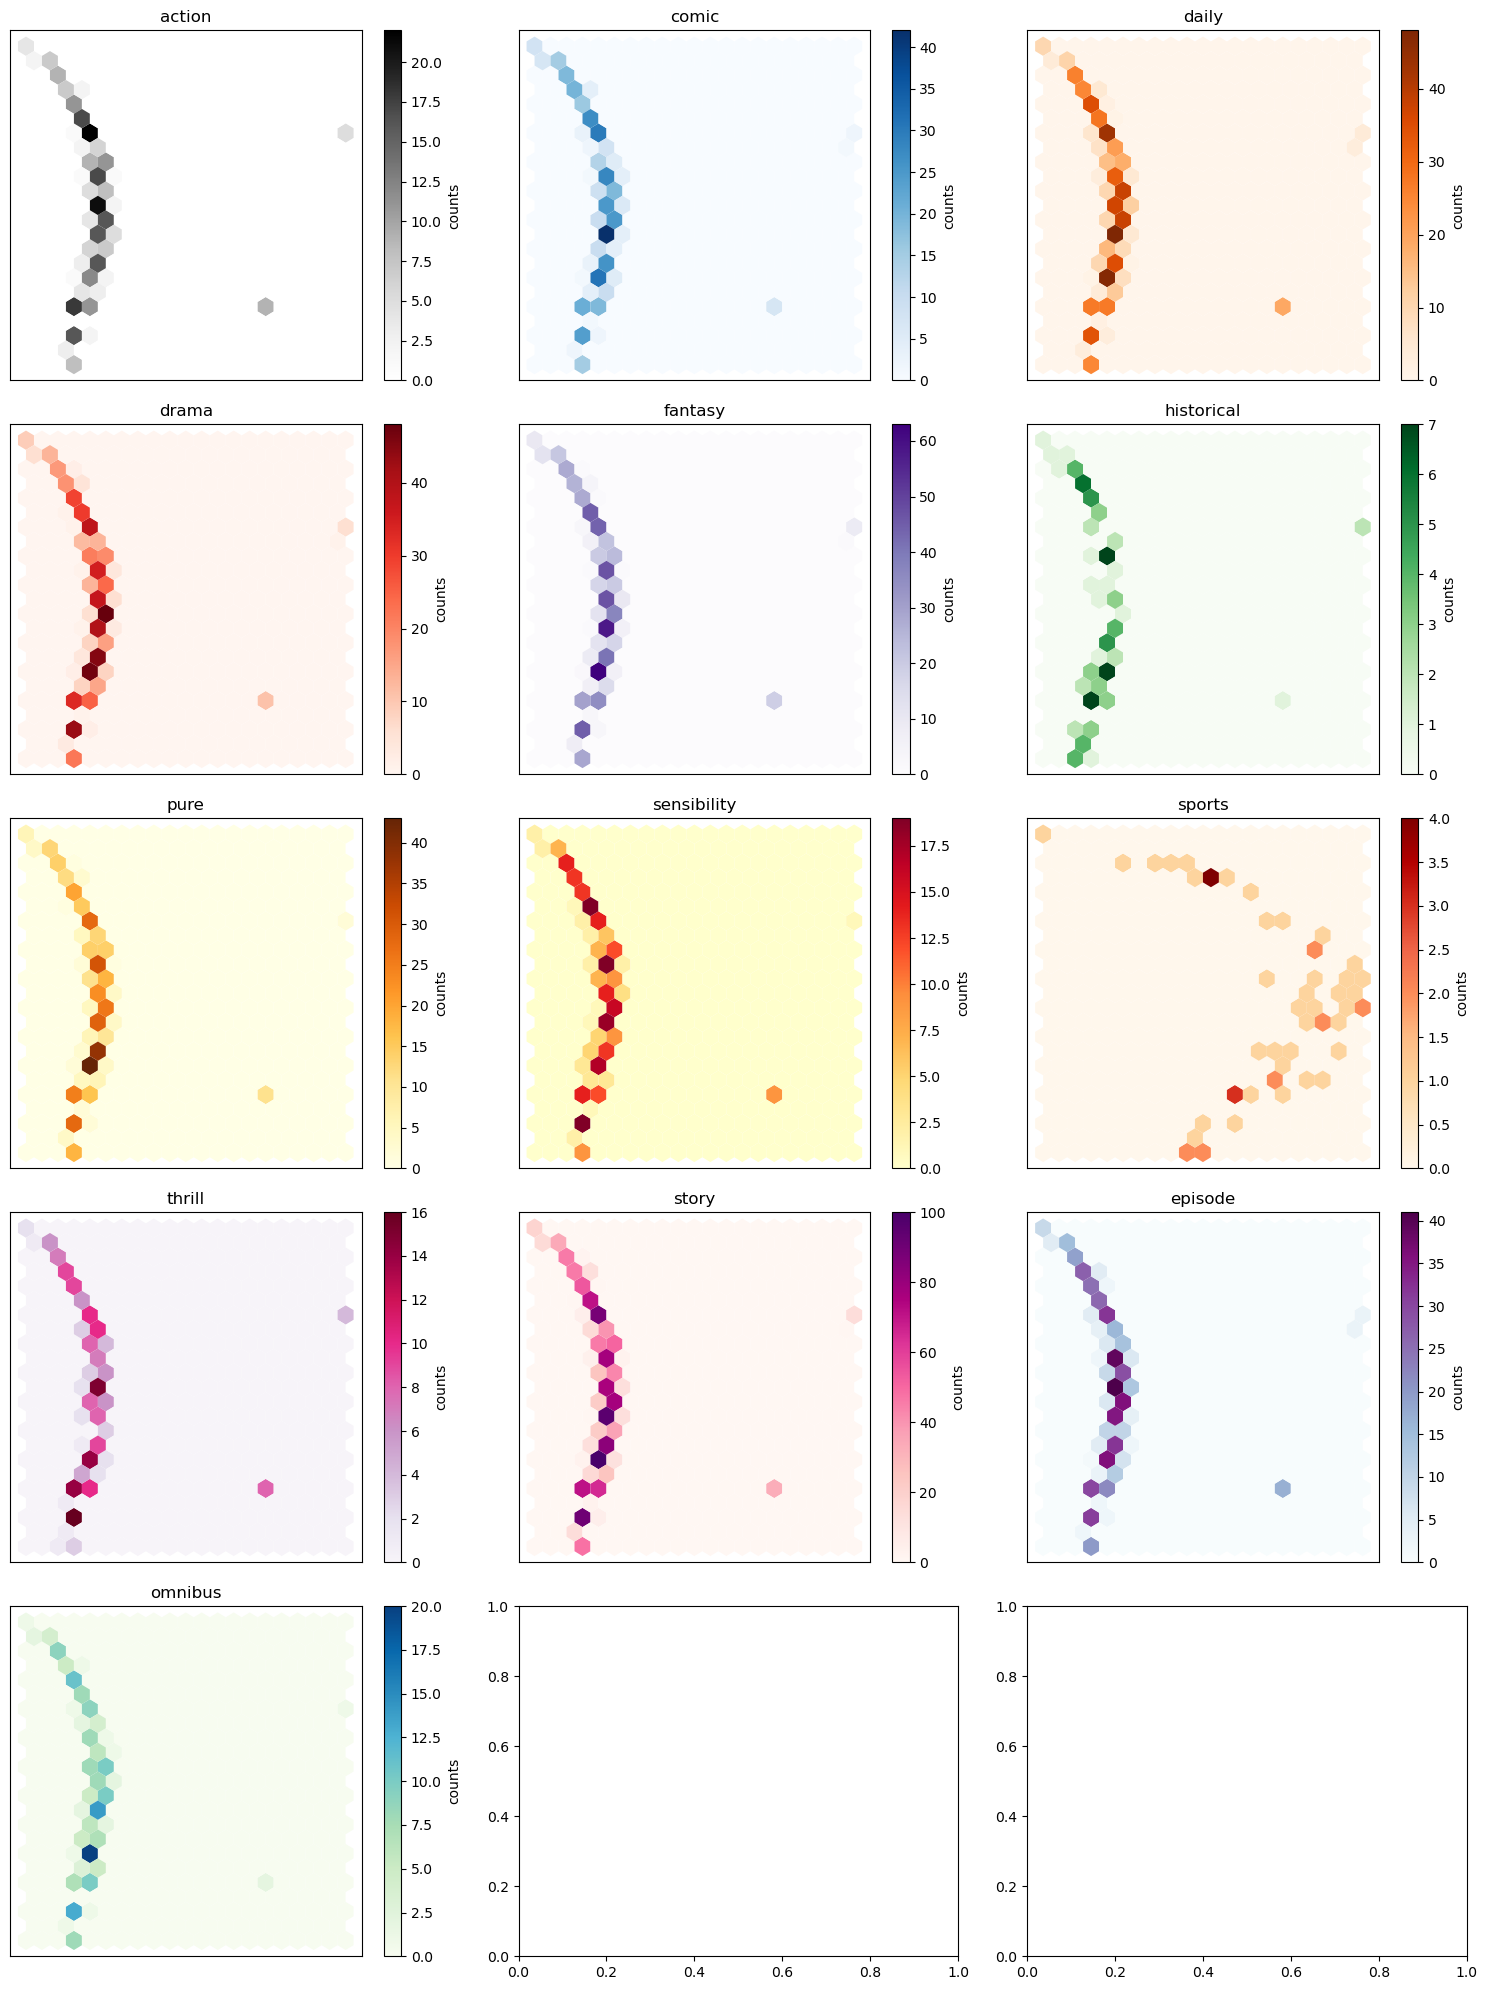

In [12]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "YlOrBr", "YlOrRd", "OrRd", "PuRd", "RdPu", "BuPu", "GnBu"]
genres = ['action', 'comic', 'daily', 'drama', 'fantasy', 'historical', 'pure', 'sensibility', 'sports', 'thrill', 'story', 'episode', 'omnibus']

for i, (genre, cmap) in enumerate(zip(genres, cmaps)):
    df_genre = df_umap[df_umap[genre] == 1]
    
    # Create a hexbin plot on the current axis
    hb = axes[i].hexbin(df_genre['x'], df_genre['y'], cmap=cmap, gridsize=20, linewidths=(0,))
    cb = fig.colorbar(hb, ax=axes[i])
    cb.set_label('counts')

    axes[i].set_title(genre)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()
